In [2]:
import sklearn  
import scipy  
import numpy as np  
import random  
import pandas as pd
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix  
from scipy.sparse.linalg import svds  
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.preprocessing import MinMaxScaler  
import matplotlib.pyplot as plt  
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy.spatial.distance import mahalanobis
from scipy.linalg import LinAlgError
from sklearn.model_selection import train_test_split
import time

# Load datasets

In [3]:
# Load datasets
df_customers = pd.read_csv('data/prepared_data/customers.csv')
df_orders = pd.read_csv('data/prepared_data/orders.csv')
df_products = pd.read_csv('data/prepared_data/products.csv')

C:\Users\moham\AppData\Local\Temp\ipykernel_15736\2719902942.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders = pd.read_csv('data/prepared_data/orders.csv')


In [4]:
df_customers.describe(include='object')

,customer_id
count,78889
unique,78889
top,'3220287651979
freq,1


In [5]:
df_orders.describe(include='object')

,name,lineitem_sku,customer_id
count,138159,138159,138159
unique,90272,389,53887
top,#146526,LOT200001A106/000-BLC-TU,'3220287651979
freq,23,4088,20688


In [6]:
df_products.drop(['published'], axis=1, inplace=True)
df_products.rename(columns={'variant_sku': 'lineitem_sku'}, inplace=True)
df_products.describe(include='object')

,lineitem_sku
count,402
unique,402
top,NEG0015
freq,1


In [7]:
print(df_customers.shape)
print(df_orders.shape)
print(df_products.shape)

(78889, 123)
(138159, 15)
(402, 84)


## content-based filtering

Evaluating Cosine similarity...
Evaluating Euclidean similarity...
Evaluating Pearson similarity...
Evaluating Mahalanobis similarity...
Evaluation Results:
Cosine: Precision=0.005808127667470774, Recall=0.014721099016890978, F1 Score=0.007433736840865277
Euclidean: Precision=0.0026535535349786607, Recall=0.00647515584552287, F1 Score=0.0033836663931305663
Pearson: Precision=0.005993690851735016, Recall=0.01522583245130297, F1 Score=0.007680215944739074
Mahalanobis: Precision=0.009816292447578402, Recall=0.02610484110820982, F1 Score=0.012757604053546605


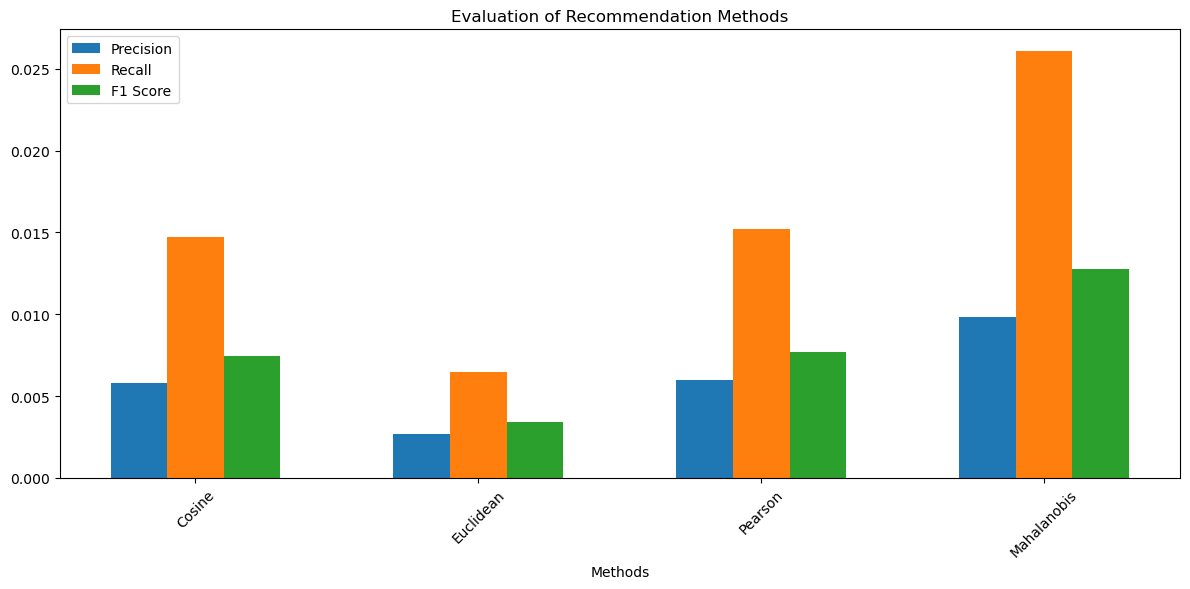

Execution time: 329.20 seconds


In [10]:
def prepare_data(df_products, df_orders):
    # create product feature matrix
    product_features = df_products.drop(columns=['lineitem_sku']).values
    product_ids = df_products['lineitem_sku']

    scaler = StandardScaler()
    product_features = scaler.fit_transform(product_features)

    product_features_df = pd.DataFrame(product_features, index=product_ids)
    
    # create user profiles
    user_profiles = df_orders.groupby('customer_id')['lineitem_sku'].apply(list)
    return product_features_df, user_profiles

# cunction that builds users profiles
def build_user_profiles(user_profiles, product_features_df, scaler=None):
    user_feature_matrix = np.zeros((len(user_profiles), product_features_df.shape[1]))
    
    for idx, (user, products) in enumerate(user_profiles.items()):
        valid_products = [p for p in products if p in product_features_df.index]
        if valid_products:
            user_feature_matrix[idx] = product_features_df.loc[valid_products].sum().values
    
    if scaler:
        user_feature_matrix = scaler.transform(user_feature_matrix)
    
    user_feature_df = pd.DataFrame(user_feature_matrix, index=user_profiles.index)
    return user_feature_df

# similarity methods
def cosine_similarity_method(user_feature_df, product_features_df):
    return cosine_similarity(user_feature_df, product_features_df)

def euclidean_similarity_method(user_feature_df, product_features_df):
    euclidean_dist = euclidean_distances(user_feature_df, product_features_df)
    return 1 / (1 + euclidean_dist)

def pearson_similarity_method(user_features, product_features):
    user_features = user_features.to_numpy()
    product_features = product_features.to_numpy()
    
    user_features_centered = user_features - np.mean(user_features, axis=1, keepdims=True)
    product_features_centered = product_features - np.mean(product_features, axis=1, keepdims=True)
    
    numerator = np.dot(user_features_centered, product_features_centered.T)
    denominator = np.sqrt(np.sum(user_features_centered**2, axis=1, keepdims=True)) @ np.sqrt(np.sum(product_features_centered**2, axis=1, keepdims=True)).T
    similarity = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0)
    return similarity

def mahalanobis_similarity_method(user_features, product_features):
    user_features = user_features.to_numpy()
    product_features = product_features.to_numpy()
    
    try:
        covariance_matrix = np.cov(product_features.T)
        inverse_covariance_matrix = np.linalg.pinv(covariance_matrix)
    except LinAlgError as e:
        print(f"Error inverting covariance matrix: {e}")
        inverse_covariance_matrix = np.eye(product_features.shape[1])
    
    similarity = np.zeros((user_features.shape[0], product_features.shape[0]))
    for i in range(user_features.shape[0]):
        for j in range(product_features.shape[0]):
            try:
                similarity[i, j] = 1 / (1 + mahalanobis(user_features[i], product_features[j], inverse_covariance_matrix))
            except ValueError:
                similarity[i, j] = 0
    return similarity

# function that recommends products
def recommend_products(similarity_matrix, product_ids, user_profiles, top_n=5):
    recommendations = {}

    for idx in range(similarity_matrix.shape[0]):
        user = user_profiles.index[idx]
        try:
            top_product_indices = np.argsort(similarity_matrix[idx])[::-1][:top_n]
            recommended_products = product_ids[top_product_indices]
            recommendations[user] = recommended_products
        except IndexError as e:
            print(f"Error generating recommendations for user {user}: {e}")
    return recommendations

# Evaluattion
def evaluate_recommendations(recommendations, test_users, test_data, k=5):
    precisions, recalls, f1_scores = [], [], []
    
    for user in test_users:
        if user in test_data.index:
            actual_products = set(test_data[user])
            recommended_products = set(recommendations.get(user, [])[:k])
            
            true_positives = len(actual_products.intersection(recommended_products))
            false_positives = len(recommended_products) - true_positives
            false_negatives = len(actual_products) - true_positives
            
            precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
            recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
            
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
    
    return np.mean(precisions), np.mean(recalls), np.mean(f1_scores)

# Plot Evaluations
def plot_evaluation_results(results):
    if not results:
        print("No results to plot.")
        return
    
    methods = list(results.keys())
    precision = [results[method]['precision'] for method in methods]
    recall = [results[method]['recall'] for method in methods]
    f1_score = [results[method]['f1_score'] for method in methods]
    
    print("Evaluation Results:")
    for method in methods:
        print(f"{method}: Precision={results[method]['precision']}, Recall={results[method]['recall']}, F1 Score={results[method]['f1_score']}")
    
    x = np.arange(len(methods))
    width = 0.2
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width, precision, width, label='Precision')
    ax.bar(x, recall, width, label='Recall')
    ax.bar(x + width, f1_score, width, label='F1 Score')
    
    ax.set_xlabel('Methods')
    ax.set_title('Evaluation of Recommendation Methods')
    ax.set_xticks(x)
    ax.set_xticklabels(methods)
    ax.legend()
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Main
def main_content_based(df_products, df_orders):
    start_time = time.time()
    product_features_df, user_profiles = prepare_data(df_products, df_orders)

    assert product_features_df.isna().sum().sum() == 0, "Product features contain NaN values"
    assert len(user_profiles) > 0, "User profiles are empty"
    assert len(product_features_df) > 0, "Product features are empty"
    assert df_orders['customer_id'].nunique() > 1, "Not enough unique users in df_orders"
    assert df_products['lineitem_sku'].nunique() > 1, "Not enough unique products in df_products"
    
    # split the daata into training and testing sets
    train_users, test_users = train_test_split(user_profiles.index, test_size=0.2, random_state=42)
    
    train_user_profiles = user_profiles.loc[train_users]
    
    scaler = StandardScaler()
    user_feature_df = build_user_profiles(user_profiles, product_features_df)
    
    user_feature_df_train = user_feature_df.loc[train_users]
    user_feature_df_test = user_feature_df.loc[test_users]
    
    scaler.fit(user_feature_df_train)
    user_feature_df_train = scaler.transform(user_feature_df_train)
    user_feature_df_test = scaler.transform(user_feature_df_test)
    user_feature_df_train = pd.DataFrame(user_feature_df_train, index=train_users)
    user_feature_df_test = pd.DataFrame(user_feature_df_test, index=test_users)
    
    methods = {
        'Cosine': cosine_similarity_method,
        'Euclidean': euclidean_similarity_method,
        'Pearson': pearson_similarity_method,
        'Mahalanobis': mahalanobis_similarity_method
    }
    
    results = {}
    
    for method_name, method in methods.items():
        print(f"Evaluating {method_name} similarity...")
        try:
            similarity_matrix = method(user_feature_df_train, product_features_df)
            
            recommendations = recommend_products(similarity_matrix, product_features_df.index, user_profiles)
            
            precision, recall, f1_score = evaluate_recommendations(recommendations, test_users, user_profiles)
            
            results[method_name] = {
                'precision': precision,
                'recall': recall,
                'f1_score': f1_score
            }
        except Exception as e:
            print(f"An error occurred with {method_name}: {e}")
            continue
    
    # Plot
    plot_evaluation_results(results)
    
    end_time = time.time()
    print(f"Execution time: {end_time - start_time:.2f} seconds")

# execute main
main_content_based(df_products, df_orders)